# シミュレーション

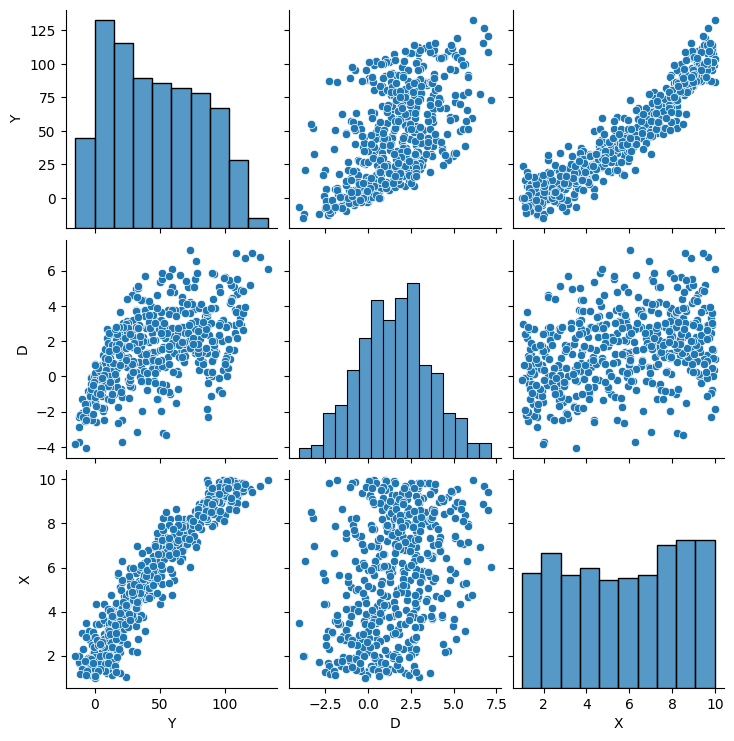

In [4]:
import numpy as np

def m(X):
    return np.log(X)

def g(X):
    return X ** 2

def gen_data(n=500, seed=0, theta=5):
    np.random.seed(seed)
    V = np.random.normal(size=n, scale=2)
    U = np.random.normal(size=n, scale=3)
    X = np.random.uniform(size=n, low=1, high=10)
    D = m(X) + V
    Y = D * theta + g(X) + U
    X = X.reshape(-1, 1)
    return Y, D, X

Y, D, X = gen_data(seed=0)

import pandas as pd
import seaborn as sns
sns.pairplot(data=pd.DataFrame(dict(Y=Y, D=D, X=X.reshape(-1, ))))

DML1を真似たやつ

1. サンプルを$K$個に分割する。
2. $k \in K$について、$k$番目のチャンクのサンプルのインデックスの集合を$I_k$とする。$i \notin I_k$のサンプルで局外関数の推定を行う：$\hat{\eta}_{0,k} = (\hat{\eta}_{0}(W_i)_{i \notin I_k})$
3. $i \in I_k$のサンプルで$\theta$を推定
4. $\hat{\theta}_{0,k}$の平均を集計


In [2]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

def dml1(Y, D, X):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    thetas = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        # 局外関数の推定
        m = LGBMRegressor(verbose=-1).fit(X[train_idx], D[train_idx])
        l = LGBMRegressor(verbose=-1).fit(X[train_idx], Y[train_idx])
        # 残差の計算
        V_hat = D[test_idx] - m.predict(X[test_idx])
        Y_res = Y[test_idx] - l.predict(X[test_idx])
        # θの推定
        theta_hat = np.mean(V_hat * V_hat) ** (-1) * np.mean(V_hat * Y_res)
        thetas.append(theta_hat)
    return np.mean(thetas)

dml1(Y, D, X)

4.996210951148309

## DML

CPU times: user 17min 19s, sys: 10.2 s, total: 17min 29s
Wall time: 2min 12s


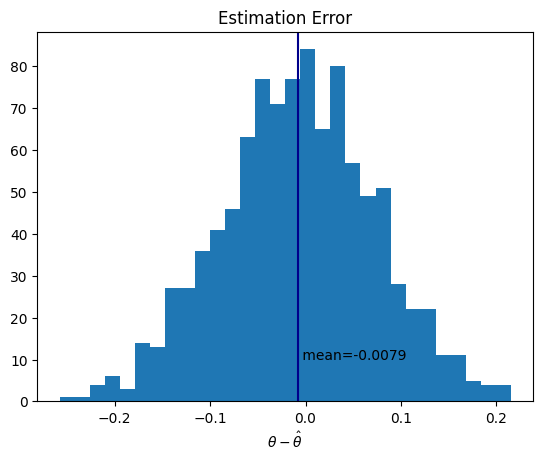

In [46]:
%%time
theta = 5
n_rep = 1000
estimation_errors = []
for i_rep in range(n_rep):
    Y, D, X = gen_data(seed=i_rep, theta=theta)
    theta_hat = dml1(Y, D, X)
    estimation_error = theta - theta_hat
    estimation_errors.append(estimation_error)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(estimation_errors, bins=30)
ax.set(xlabel=r"$\theta - \hat{\theta}$", title="Estimation Error")

mean_error = np.mean(estimation_errors)
ax.axvline(mean_error, color="darkblue")
ax.text(mean_error, 10, f" mean={mean_error:.2g}")

fig.show()

## もしCross Fittingがなければ

In [47]:
def estimate_without_cross_fitting(Y, D, X):
    # 局外関数の推定
    m = LGBMRegressor(max_depth=4, verbose=-1).fit(X, D)
    l = LGBMRegressor(max_depth=4, verbose=-1).fit(X, Y)
    # 残差の計算
    V_hat = D - m.predict(X)
    Y_res = Y - l.predict(X)
    # θの推定
    theta_hat = np.mean(V_hat * V_hat) ** (-1) * np.mean(V_hat * Y_res)
    return theta_hat

estimate_without_cross_fitting(Y, D, X)

4.8689337039631475

CPU times: user 2min 30s, sys: 1.3 s, total: 2min 31s
Wall time: 19.2 s


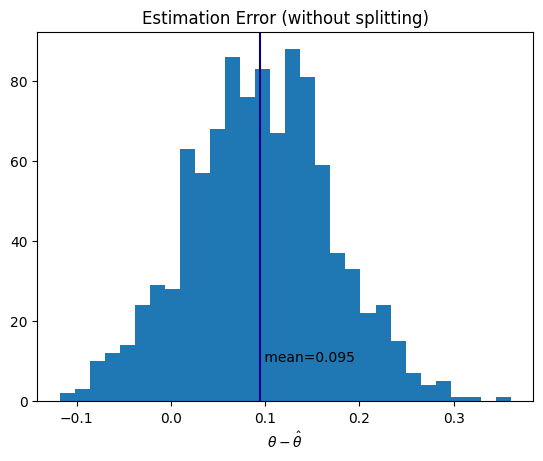

In [48]:
%%time
n_rep = 1000
estimation_errors = []
for i_rep in range(n_rep):
    Y, D, X = gen_data(seed=i_rep, theta=theta)
    theta_hat = estimate_without_cross_fitting(Y, D, X)
    estimation_error = theta - theta_hat
    estimation_errors.append(estimation_error)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(estimation_errors, bins=30)
ax.set(xlabel=r"$\theta - \hat{\theta}$", title="Estimation Error (without splitting)")

mean_error = np.mean(estimation_errors)
ax.axvline(mean_error, color="darkblue")
ax.text(mean_error, 10, f" mean={mean_error:.2g}")

fig.show()

## ライブラリと一致するか

In [9]:
theta = 5
Y, D, X = gen_data(seed=0, theta=theta)
theta_hat = dml1(Y, D, X)
print(f"{theta=:.1f}, {theta_hat=:.3f}")

theta=5.0, theta_hat=4.996


In [20]:
df = pd.DataFrame(X, columns=["x"])
df["y"] = Y
df["d"] = Y
df.head()

,x,y,d
0,8.397135,99.940053,99.940053
1,7.304758,67.200958,67.200958
2,8.947698,104.094708,104.094708
3,9.699176,127.140504,127.140504
4,7.972729,91.577762,91.577762


In [28]:
l = LGBMRegressor(verbose=-1, n_estimators=100, max_depth=4)
m = LGBMRegressor(verbose=-1)
    
from doubleml import DoubleMLData
data = DoubleMLData(df, y_col="y", d_cols="d", x_cols=["x"])

from doubleml import DoubleMLPLR
np.random.seed(1)
dml = DoubleMLPLR(data, l, m)
dml.fit()
print(dml)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x']
Instrument variable(s): None
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LGBMRegressor(max_depth=4, verbose=-1)
Learner ml_m: LGBMRegressor(verbose=-1)
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[10.77148372]]
Learner ml_m RMSE: [[10.86900956]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
       coef   std err           t  P>|t|     2.5 %   97.5 %
d  0.989565  0.002293  431.535933    0.0  0.985071  0.99406
